# GroupMe Analytics

In [1]:
import groupy
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from nltk import tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import sys, re
import numpy as np
import seaborn as sns
from random import random
from operator import add
from pandas.plotting import table
from pprint import pprint
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)
pd.set_option('display.max_colwidth', 400)
%matplotlib inline

In [2]:
from groupy.client import Client
file = open("./groupme-token.txt", "r") 
token = file.read()
client = Client.from_token(token)

In [3]:
groups = client.groups
psi_group = ""
for group in client.groups.list():
    if (group.name == "Psi"):
        psi_group = group
        print(group.name)

group = psi_group
members = psi_group.members

Psi


In [4]:
def find_uid(members, nickname):
    for m in members:
        if nickname == m.nickname:
            return m.user_id  
    return None

msgs = []
messages = group.messages.list_all()
length = 0
for m in messages:
    length += 1
    msgs.append(m)
print(length)

2928


## Preprocessing: feeding messages into a data frame + extracting features

In [5]:
%%capture
#populate messages list 
profanity_list = ['fuck', 'shit', 'fuk', 'damn', 'bitch', 'ass', ' ass ', ' ass.', 'douche', 'asshole', 'douchebag', 'fucker', 'dick', 'cunt', 'fucking']
profanity_list_2 = ['fuck', 'shit', 'fuk', 'damn', 'bitch', ' ass ', ' ass.', 'douche', 'asshole', 'douchebag', 'fucker', 'dick', 'cunt', 'fucking']
gay_list = ["gay","gey"]

#put features into tuples 
index = 0
num_exceptions = 0
tup_msgs = []
for ex in msgs:
    try:
        fucks_given = 0
        profanity = 0
        selfname = ex.name
        self_like = 0
        for uid in ex.favorited_by:
            if find_uid(members, selfname) == uid:
                self_like = 1
        try:
            text = str(ex.text).lower()  #lowercase
        except:
            text = str(ex.text)
        if any(word in text for word in profanity_list_2):
            print(text)
        text2 = text.split()
        for word in text2:
            if(word in profanity_list):
                profanity = profanity + 1
        if 'fuck' in text:
            fucks_given = 1
        tup = (ex.name, ex.user_id, ex.created_at, text, len(ex.favorited_by), self_like, profanity, fucks_given, len(text2))
        tup_msgs.append(tup)
        index += 1
    except Exception as e:
        num_exceptions += 1
        print(ex, e)

print("Number of weird shit: ", num_exceptions)

### Create DataFrame from above processed data

In [6]:
colnames = ['name', 'uid', 'datetime', 'text', 'num_likes', 'self_like', 'profanity', 'fucks_given', 'word_count']
df = pd.DataFrame.from_records(tup_msgs, columns = colnames)
# df.head()

## Most liked messages in the group chat

In [7]:
print("most liked messages in groupme history")
df[["name", "text", "num_likes"]].sort_values(by="num_likes", ascending=False).head(15)

most liked messages in groupme history


,name,text,num_likes
2250,Alexander Canzone,"my internship literally went bankrupt today, doing well",61
2223,Max Grout,to hammered from the tour and couldn't make it to phi mu formal. looking slow for future mixers,54
394,Matt Armstrong,who the fuck shit in a cup and put in front of my room again,53
1141,Riley Jameson,when your date says “i gotta go but i’ll see you around”,52
841,Sam Grossman,"awesome experience for rohan from the new pc, and the rest of the new pc, one last big dinner as a house, a great way to go out, even though some of us didn’t get any filet, and brant couldn’t eat because he’s allergic to sulfites. we do fucking care about you, we love you all and hope we can all ride into the last weekend with you with beer flow and great times, but don’t forget, we blow",51
2238,Alexander Canzone,@john snyder i'm glad this terrible and potentially life altering event provided you with some humor!,50
2782,Reed Fratt,but they don’t know me,50
136,Ian Capell,too fitting,47
2248,Alexander Canzone,"jimmy didn't even capitalize his name, must be a wreck",47
1726,Apollo Brown,summary of my hunt for a formal date,47


## Most profane messages in the group chat

In [8]:
print("most profane messages")
df[["name", "text", "num_likes","profanity"]].sort_values(by="profanity", ascending=False).head(10)

most profane messages


,name,text,num_likes,profanity
1656,James Harrison,"whoever stole my fucking cigarettes, i will put a fucking knife in you if i find out who you are, you’re actually such a fucking piece of shit",11,4
1610,GroupMe,cooper paston changed the topic to: fuck fuck fuck fuck its already friday friday,13,4
920,Nick Kumar,i don’t get why we leave anything out if the trash is in the same room. take the fucking 2 seconds necessary to throw your shit out and don’t fuck everyone else over.,26,3
394,Matt Armstrong,who the fuck shit in a cup and put in front of my room again,53,2
2374,David Kiger,can’t wait til sig phi tries to steal shit from our house and i fuck them up,4,2
152,James Harrison,"also, to whoever keeps peeing and vomiting in the second floor water fountain, stop, you’re a fucking douche",29,2
1258,David Millar,i was out there fucking mopping bathrooms. get your shit together and clean the house,2,2
164,miron,heads up im sending all seniors a venmo with what they are getting of their security deposit(max 250). some of you got fined for breaking shit this semester/year and its deducted directly from ur deposit. a lot of u also didnt do philanthropy or missed hm which is $40 per but im doing $20 per. that explains why some of you arent getting all 250 dont text me asking for explanation cause idc abo...,6,1
1635,David Millar,i can't believe you just posted that hassi fuck you,0,1
2612,David Miron,fuck you,0,1


## Create Users DataFrame for aggregate info

In [22]:
users = pd.DataFrame(np.asarray(members), columns = ["name"])
uids = pd.DataFrame(np.asarray(members), columns = ["uid"])

grouped_df = df.groupby(["uid"], sort=True)
count_df = grouped_df.size().to_frame(name='message_count')
total_messages = count_df.sum()[0]
mean_df = grouped_df.agg({'name': 'min', 'num_likes': 'mean', 
                          'self_like': 'sum', 'profanity': 'mean', 
                          'fucks_given': 'sum', 'word_count' : 'mean'})

join_df = mean_df.join(count_df)
join_df['percent_of_total_msgs'] = join_df['message_count']/total_messages *100
results_df = join_df.reset_index()

In [23]:
results_df[["name", "num_likes", "message_count"]].sort_values(by="num_likes", ascending=False).head(20)

,name,num_likes,message_count
78,Max Grout,18.000000,3
35,Jeremy Schwartz,16.000000,5
15,Dean Brigham,13.250000,4
16,Ben Wexler,12.500000,6
77,Will Granath,11.888889,9
57,Connor Scro,11.600000,5
22,Pehuen Moure,11.583333,12
31,Nick Romanoff,11.500000,2
60,James Wood,10.800000,5
75,Mike Nercessian,10.705882,17


In [24]:
results_df[results_df.message_count>10][["name", "num_likes", "message_count"]].sort_values(by="num_likes", ascending=False).head(30)

,name,num_likes,message_count
22,Pehuen Moure,11.583333,12
75,Mike Nercessian,10.705882,17
44,Mike Southworth,10.157895,19
14,harrison p,9.022222,45
82,Jack Strougo,8.897059,68
83,Ben Rashbaum,8.593750,32
56,Dante Pavone,8.136364,22
46,Sam Brickman,7.916667,12
43,Mick Verini,7.851852,27
17,Josh Fajiram,7.076923,13


In [25]:
results_df["self_like_percent"] = results_df["self_like"]/results_df["message_count"] * 100
results_df[["name", "self_like", "message_count", "self_like_percent"]].sort_values(by="self_like", ascending=False).head(15)

,name,self_like,message_count,self_like_percent
28,Gabe Goldberg,5,6,83.333333
2,John Snyder,4,21,19.047619
14,harrison p,3,45,6.666667
43,Mick Verini,2,27,7.407407
3,Alec Abaunza,2,62,3.225806
60,James Wood,2,5,40.000000
55,David Millar,1,69,1.449275
39,Ryman Seeley,1,60,1.666667
41,Riley Jameson,1,25,4.000000
82,Jack Strougo,1,68,1.470588


In [26]:
results_df["profanity_percent_per_message"] = results_df["profanity"] * 100
results_df[["name", "profanity_percent_per_message", "message_count"]].sort_values(by="profanity_percent_per_message", ascending=False).head(20)

,name,profanity_percent_per_message,message_count
9,Nick Kumar,21.739130,23
57,Connor Scro,20.000000,5
10,James Harrison,18.000000,50
0,Ian Capell,17.241379,29
64,Joey Oloyo,16.666667,6
16,Ben Wexler,16.666667,6
44,Mike Southworth,15.789474,19
17,Josh Fajiram,15.384615,13
25,David Miron,12.101911,157
20,Connor Ostrander,10.752688,186


In [27]:
results_df[["name", "fucks_given", "message_count"]].sort_values(by="fucks_given", ascending=False).head(20)

,name,fucks_given,message_count
20,Connor Ostrander,16,186
25,David Miron,13,157
74,Sam Barnett,7,83
26,Matt Armstrong,7,145
87,GroupMe,5,159
10,James Harrison,4,50
68,Jake Caruso,4,51
27,Levy Agaronnik,4,72
23,Ryan Sharkey,4,137
0,Ian Capell,4,29


In [28]:
results_df[["name", "message_count", "percent_of_total_msgs"]].sort_values(by="message_count", ascending=False).head(20)

,name,message_count,percent_of_total_msgs
20,Connor Ostrander,186,6.352459
87,GroupMe,159,5.430328
25,David Miron,157,5.362022
26,Matt Armstrong,145,4.952186
23,Ryan Sharkey,137,4.678962
79,Alexander Messados,101,3.449454
74,Sam Barnett,83,2.834699
27,Levy Agaronnik,72,2.459016
38,Sam Grossman,72,2.459016
45,Apollo Brown,69,2.356557


In [29]:
results_df[["name", "word_count", "message_count"]].sort_values(by="word_count", ascending=False).head(20)

,name,word_count,message_count
22,Pehuen Moure,18.583333,12
1,David Kiger,17.031250,32
47,Hudson Lifflander,16.500000,2
15,Dean Brigham,15.250000,4
43,Mick Verini,11.851852,27
29,Nolan Berkenfeld,11.600000,35
63,Will Zink,11.400000,55
57,Connor Scro,11.000000,5
64,Joey Oloyo,10.666667,6
54,Pravir Samtani,10.500000,2


## visualize features

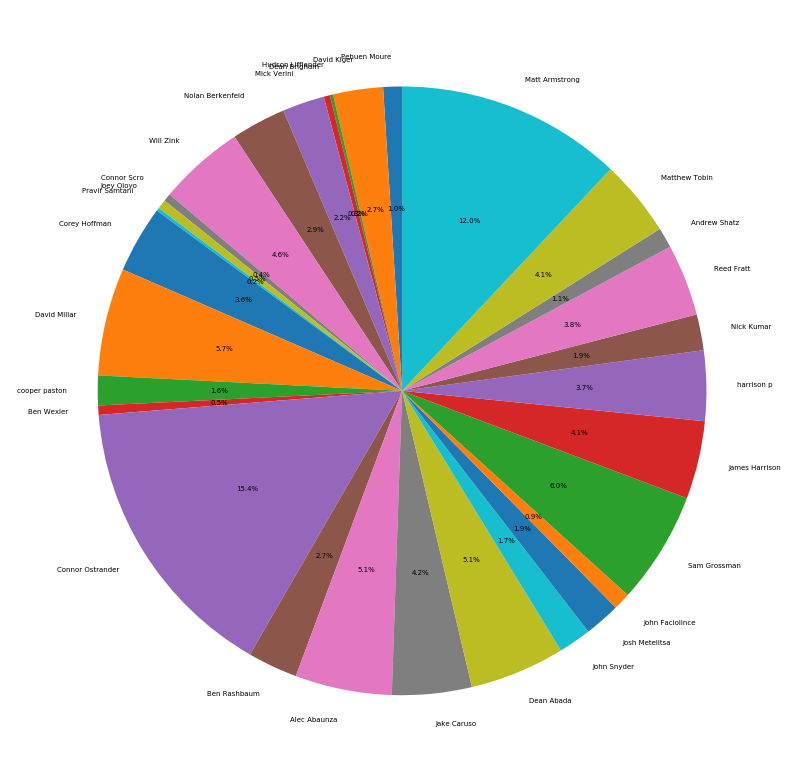

In [30]:
#Pie chart of message counts
top_messagers = results_df[["name", "word_count", "message_count"]].sort_values(by="word_count", ascending=False).head(30)

plt.figure(figsize=(30,30))
# plot chart
ax1 = plt.subplot(121, aspect='equal')
top_messagers.plot(kind='pie', y = 'message_count', ax=ax1, autopct='%1.1f%%', 
 startangle=90, shadow=False, labels=top_messagers['name'], legend = False, fontsize=7)
plt.axis('off')
plt.show()

## Some time series stuff

### by month

Groupme useage by month


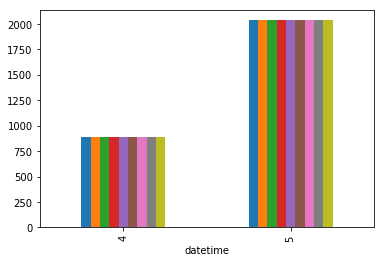

In [20]:
#Usage patterns
print("Groupme useage by month")
df.groupby(df.datetime.dt.month).count().plot(kind="bar", legend=False)

### by hour

Groupme useage by hour of day


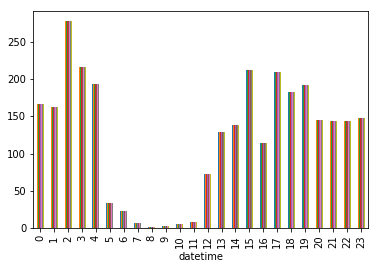

In [21]:
#Usage patterns
print("Groupme useage by hour of day")
df.groupby(df.datetime.dt.hour).count().plot(kind="bar", legend=False)

### running use frequency by day/hour since the group chat was created

Usage since inception


/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


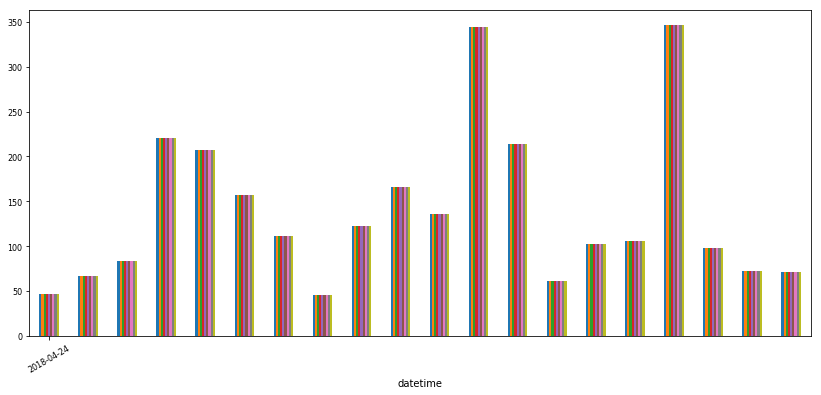

In [30]:
#note: this one takes a sec to complete
print('Usage since inception')
n = 20

ax = df.groupby(df.datetime.dt.date).count().plot(kind="bar", legend=False, rot=30, fontsize=8, figsize=(14,6))
ticks = ax.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(ticks[::n])
ax.xaxis.set_ticklabels(ticklabels[::n])

ax.figure.show()

## Analyzing Lexicon: 
#### Which words best define each member of the group chat? 
#### Which are the most commonly used?

In [17]:
#TFIDF Scores 
#first, collapse everyone's messages into personalized documents 
documents = []
names = np.asarray(results_df['name'])
for i in names:
    document = ""
    msgs = df[df['name']==str(i)]['text']
    for i in msgs:
        document += (str(i) + " ")
    documents.append(document)


#create the vectorizer
tfidf = TfidfVectorizer(max_df=0.9,
                        ngram_range=(1, 1),
                        stop_words='english',
                        strip_accents='unicode', analyzer = 'word')

#run the multiplicaiton
tfidf_matrix =  tfidf.fit_transform(documents)
feature_names = tfidf.get_feature_names() 


/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


## Most common words in the group

In [57]:
indices = np.argsort(tfidf.idf_)#[::1]
tfidf_matrix_2 = tfidf_matrix.todense()
top_n = 100
top_features = [feature_names[i] for i in indices[:top_n]]
print("Most used words in the groupme: ")
print(top_features)

Most used words in the groupme: 
['like', 'just', 'house', 'room', 'fuck', 'come', 'don', 'need', 'dinner', 'll', 'phi', 'time', 'let', 'lol', 'great', 'formal', 'want', 'https', 'actually', 'guys', 'com', 'groupme', 'did', 'fucking', 'know', 'girls', 'day', 'tomorrow', 'does', 'beer', 'gonna', 'tonight', 'lot', 'connor', 'people', 'make', 'psi', 'got', 'pong', 'going', 'getting', 'way', 'new', 'rn', 'car', 'sig', '10', 'looking', '500', 'date', 'night', 'nice', 'wanna', 'shit', 'alexander', 'slope', 'left', '30', 'right', 'love', 'seniors', 'tn', 'dining', 'yo', 'doing', 'use', 'thing', 'think', 'sam', 'play', 'ostrander', 'good', 'said', 'nibs', 'armstrong', 'miron', 'dave', 'outside', 'eat', 'phone', 'faux', 'caruso', 'poll', 'big', 'kid', 'today', 'text', 'food', 'start', 'hall', 'canzone', 'wants', 'took', 'pregame', 'long', 'sure', 'jack', 'rusk', 'send', 'things']


In [58]:
i = 0
j = 0
dicts = []
for person in names:
    persondict = {}
    for word in feature_names:
        if tfidf_matrix[i,j] != 0:
            persondict[word] = tfidf_matrix[i,j]
        j += 1
    j = 0
    i += 1
    #print('person done')
    dicts.append(persondict)
#sorted(tfidf_matrix_2[5].tolist()[0])[::-1]

In [60]:
import operator
j = 0
words_dict = {}
for i in dicts:
    sorted_vals = sorted(i.items(), key=operator.itemgetter(1), reverse=True)
    words_dict[str(names[j])] = sorted_vals[0:15]
    j += 1

## Most distinctive words per person 

* Determined by TF-IDF scores
* Essentially, the words that each person uses way more often than everyone else 

In [61]:
for entry in words_dict:
    print("Top words for " + str(entry) + ": ")
    for w in words_dict[entry]:
        print(w)
    print('\n')

Top words for Ian Capell: 
('room', 0.2629562976026249)
('milles', 0.18996646348933346)
('zack', 0.18996646348933346)
('need', 0.16727457241233562)
('leave', 0.1589856173096293)
('dining', 0.14507261876104383)
('808', 0.13335649898226176)
('balls', 0.13335649898226176)
('bootie', 0.13335649898226176)
('dsa', 0.13335649898226176)
('era', 0.13335649898226176)
('includes', 0.13335649898226176)
('infused', 0.13335649898226176)
('remix', 0.13335649898226176)
('riser', 0.13335649898226176)


Top words for David Kiger: 
('buses', 0.3400456353842844)
('formal', 0.17919657330592323)
('pregame', 0.15871540668148512)
('slope', 0.14839103677966864)
('winery', 0.13640692030161752)
('yes', 0.1285135606604367)
('30pm', 0.12492673158449408)
('45am', 0.12492673158449408)
('leaving', 0.12196671288031508)
('starts', 0.11046340429663416)
('date', 0.10899701870384801)
('tables', 0.10530121934572592)
('day', 0.09567584298662371)
('meeting', 0.09382103062860246)
('zink', 0.09382103062860246)


Top words for 

('know', 0.17424858719731176)
('formal', 0.16317990390490794)
('phi', 0.15818792459536846)
('house', 0.13533411246150548)


Top words for Alexander Messados: 
('mcdonalds', 0.22824318842656952)
('boi', 0.16949447615914798)
('house', 0.15682886828689746)
('come', 0.15024017088496078)
('pm', 0.149871341453858)
('broke', 0.1369459130559417)
('having', 0.13181636515750594)
('28', 0.12338015628714323)
('11', 0.12324440681725356)
('ass', 0.11624060688593904)
('senior', 0.11624060688593904)
('dolla', 0.11299631743943198)
('mattress', 0.11299631743943198)
('scheming', 0.11299631743943198)
('drink', 0.11031897841933724)


Top words for Zack Milles: 
('inbetween', 0.29857011331715805)
('screen', 0.29857011331715805)
('using', 0.29857011331715805)
('wristband', 0.29857011331715805)
('hand', 0.27344205354867385)
('heinous', 0.27344205354867385)
('btw', 0.23048535164469575)
('photo', 0.23048535164469575)
('shots', 0.23048535164469575)
('afters', 0.22093210669564206)
('aux', 0.2053572918762115)
('bl

In [70]:
results_df.to_csv("members_psi.csv", encoding='utf-8')
df.to_csv("messages_psi.csv", encoding='utf-8')